In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import math
import sklearn.metrics as metrics
import sklearn.datasets as sk_datasets
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split

In [2]:
'''
 Since we are dealing with logistic regression,
 the hypothesis is defined as:

                    1
       F(x) = ----------------
                1 + exp^(-x)

 However, its implementation may result in overflow
 if x is too large, then, the version implemented 
 here is more stable with similar results, and is
 defined as:
 
                  exp^(x)
       F(x) = ----------------, if x < 0
                1 + exp^(x) 
                
                    1
       F(x) = ----------------, if x >= 0
                1 + exp^(-x) 
'''
def hypothesis(theta,X,stable=False):
    
    dot = np.dot(X,theta)
    
    #Regular Sigmoid Function        
    if (stable == False):        
        h = 1 / (1 + np.exp(-dot))
    
    else:
    #Stable Sigmoid Function
        num = (dot >= 0).astype(np.float128)
        dot[dot >= 0] = -dot[dot >= 0]	
        exp = np.exp(dot)
        num = np.multiply(num,exp)
        h = num / (1 + exp)
    
    return h

# Apply a multi class classification of the samples
# regarding an optimized thetas
def classify_multiclass(theta , X):
	X = np.insert(X,0,1,axis=1)
	classes = []
	max_prob = np.array([])
	for m in theta:			
		h = Hypothesis(theta[m],X)
		if max_prob.size == 0:
			max_prob = h
			classes = [m]*h.shape[0]
		for i in range(len(h)):
			if h[i] > max_prob[i]:
				max_prob[i] = h[i]
				classes[i] = m
	X = np.delete(X,0,axis=1)
	return classes

# Given a threshold apply a 
# binary classification of the samples
# regarding an optimized theta
def classify(theta, X, th):
    X = np.insert(X, 0, 1, axis=1)
    y = hypothesis(theta, X)
    y[y >= th] = 1
    y[y < th] = 0
    X = np.delete(X, 0, axis=1)
    return y

def predict(theta,X):
    X = np.insert(X, 0, 1, axis=1)
    y = hypothesis(theta, X)
    X = np.delete(X, 0, axis=1)
    return y



In [8]:
#-----------------------------------
#   Evaluation Metrics and Loss Functions
#-----------------------------------

def cross_entropy_loss(h, y):
    # y.log(h) + (1-log(h) . 1-y)
    # log probability * inverse of the log probabality 
	eps = np.finfo(np.float).eps
	h[h < eps] = eps
	h[h > 1.-eps] = 1.-eps
	return np.multiply(np.log(h),y) + np.multiply((np.log(1-h)),(1-y))

def accuracy_score(Y,predY,mode='binary'):
	acc = 0.0
	if (mode=='binary'):
		TP = ((predY == Y) & (predY == 1.)).sum()
		TN = ((predY == Y) & (predY == 0.)).sum()	
		acc = (TP + TN) / Y.shape[0]
	elif (mode=='multi'):
		TP = (predY == Y).sum()
		acc = TP / Y.shape[0]
	return acc

def precision_score(Y,predY,mode='binary'):
	precision = 0.0
	if (mode=='binary'):
		TP = ((predY == Y) & (predY == 1)).sum()
		FP = ((predY != Y) & (predY == 1)).sum()
		precision = TP / (TP + FP)
	elif (mode=='multi'):
		classes=np.unique(Y)
		for c in classes:
			TP = ((predY == Y) & (predY == c)).sum()
			FP = ((predY != Y) & (predY == c)).sum()
			precision += TP / (TP + FP)
		precision /= len(classes)
	return precision

def recall_score(Y,predY,mode='binary'):
	recall = 0.0
	if (mode=='binary'):
		TP = ((predY == Y) & (predY == 1)).sum()
		FN = ((predY != Y) & (predY == 0)).sum()
		recall = TP / (TP + FN)
	elif (mode=='multi'):
		classes=np.unique(Y)
		for c in classes:
			TP = ((predY == Y) & (predY == c)).sum()
			FN = ((predY != Y) & (Y == c)).sum()
			recall += TP / (TP + FN)
		recall /= len(classes)
	return recall

def fb_score(Y,predY,beta,mode='binary'):
	fbscore = 0.0
	if (mode=='binary'):
		precision = precision_score(predY,Y)
		recall = recall_score(predY,Y)
		fscore = (1 + beta*beta)*((precision*recall)/((beta*beta*precision)+recall))
	elif (mode=='multi'):
		precision = precision_score(predY,Y,'multi')
		recall = recall_score(predY,Y,'multi')
		fscore = (1 + beta*beta)*((precision*recall)/((beta*beta*precision)+recall))
	return fscore

In [9]:
#-----------------------------------
#   Gradient Descent
#-----------------------------------

def BGD(X, y, alpha, iterations):

    X = np.insert(X, 0, 1, axis=1)

    nsamples = X.shape[0]
    nfeatures = X.shape[1]
    theta = np.zeros(nfeatures)
    J=[]

    for i in range(iterations):

        h = hypothesis(theta,X)

        error = h - y

        grad = np.dot(X.transpose(),error)/nsamples

        theta = theta - alpha * grad

        J.append(error)
#         J.append(error)

    X = np.delete(X,0,axis=1)
    plt.figure()
    plt.plot(J)    
    plt.ylabel('Error')
    plt.xlabel('iterations')
    plt.show()

    return theta, J[iterations-1]

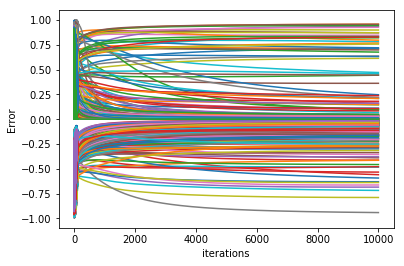


--- Error
[ 3.77774446e-03  2.53955817e-03 -1.99142344e-02 -2.93677421e-02
 -4.31270905e-02 -1.31486985e-01 -1.99817560e-01  2.46991661e-04
  1.21119940e-05 -2.83109895e-02 -4.27766190e-02  1.50300542e-15
  5.94027124e-03 -5.60296801e-01  3.44745796e-11  1.55086873e-03
 -1.92933414e-01 -1.07089645e-01 -4.32065965e-02  5.67042496e-05
 -1.40210052e-02  3.38985466e-02  4.20723432e-02 -4.13040916e-01
 -3.67862378e-02 -3.89878850e-01  1.02193497e-01  1.97689651e-02
 -4.43393619e-02  7.82649541e-01 -1.40345102e-01  1.12658557e-03
 -2.66486406e-02 -4.18307225e-02 -1.33298578e-01  2.50147782e-05
 -5.24698634e-02 -2.06919823e-02 -7.90309264e-01  8.37020768e-01
 -2.99450404e-01 -8.13357968e-02 -6.90363826e-02 -5.71466449e-02
 -1.16815396e-01 -3.70423942e-02 -6.72298855e-02 -4.19403812e-02
 -7.94242633e-02  4.71526781e-01 -6.45387688e-02 -1.95190320e-01
  1.82320887e-05  4.71812591e-06  2.00240599e-04 -5.59913546e-02
 -3.45413443e-02 -4.78708877e-02 -1.00748328e-01 -4.84700485e-01
 -7.02473995e-

In [10]:
#-----------------------------------
#   Logistic Regression - Toy Example
#-----------------------------------

X,y = load_breast_cancer(return_X_y=True)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

X_train = np.asarray(X_train)
y_train = np.asarray(y_train)
X_test = np.asarray(X_test)
y_test = np.asarray(y_test)

theta,error = BGD(X_train,y_train,0.00001,10000)

print("\n--- Error")
print(error)

predY = classify(theta,X_test,0.6)
pred = predict(theta,X_test)
print("\n--- Hypothesis")
print(pred)
print("\n--- Classification")
print(predY)
print("\n--- Expected Output")
print(y_test)

acc = accuracy_score(predY,y_test)
sk_acc = metrics.accuracy_score(y_test,predY)
pre = precision_score(predY,y_test)
sk_pre = metrics.precision_score(y_test,predY)
recall = recall_score(predY,y_test)
sk_recall = metrics.recall_score(y_test,predY)
f = fb_score(predY,y_test,1)
sk_f = metrics.f1_score(y_test,predY)

print()
print("myAccuracy: ", str(acc))
print("skAccuracy: ", str(sk_acc))
print()
print("myPrecision: ",str(pre))
print("skPrecision: ",str(sk_pre))
print()
print("myRecall: ",str(recall))
print("skRecall: ",str(sk_recall))
print()
print("myF1Score: ",str(f))
print("skF1Score: ",str(sk_f))


In [ ]:
#-----------------------------------
# MultiClass Classification - Toy Exmaple
#-----------------------------------


X,y = sk_datasets.make_classification(n_samples = 500, n_features = 20, n_classes = 4, n_clusters_per_class=1, n_informative=4,
										n_redundant=0)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1)

print(X_train)
print(y_train)

classes = np.unique(y)
print(classes)
theta = {}

for c in classes:

	cy = np.copy(y_train)

	cy[y_train != c] = 0.
	cy[y_train == c] = 1.

	theta[c],acc = BGD(X_train,cy,0.0001,50000)

predY = classify_multiclass(theta,X_test)
print("\n--- Classification")
print(predY)
print("\n--- Expected Output")
print(y_test)

acc = accuracy_score(y_test,predY,mode='multi')
sk_acc = metrics.accuracy_score(y_test,predY)
pre = precision_score(y_test,predY,mode='multi')
sk_pre = metrics.precision_score(y_test,predY,average='micro')
recall = recall_score(y_test,predY,mode='multi')
sk_recall = metrics.recall_score(y_test,predY,average='micro')
f = fb_score(y_test,predY,1,mode='multi')
sk_f = metrics.f1_score(y_test,predY,average='micro')

print()
print("myAccuracy: ", str(acc))
print("skAccuracy: ", str(sk_acc))
print()
print("myPrecision: ",str(pre))
print("skPrecision: ",str(sk_pre))
print()
print("myRecall: ",str(recall))
print("skRecall: ",str(sk_recall))
print()
print("myF1Score: ",str(f))
print("skF1Score: ",str(sk_f))